# X Posts Sentiment Analysis


# Connect To Google Drive (Ignore this if you are working locally)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "drive/MyDrive/sentiment140.zip"

Archive:  drive/MyDrive/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


# Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')                              # Turn the warnings off.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Dataset

## Reading the dataset

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.shape

(1600000, 6)

In [5]:
# choose the text and target columns only
data = df[[5, 0]]

In [6]:
print(data.shape)
display(data.head())

(1600000, 2)


,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [7]:
data = data.rename(columns={5: 'text', 0:'class'})
data.head()

,text,class
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [8]:
data['class'].value_counts()

,count
class,
0,800000
4,800000


In [9]:
data.isnull().sum()

,0
text,0
class,0


## Sampling (50,000 samples from each class)

In [10]:
n = data.loc[data['class']== 0] # negative samples
p = data.loc[data['class']== 4] # positive samples

n = n.sample(n=50000, random_state=2024)
p = p.sample(n=50000, random_state=2024)

# concatenating
data = pd.concat([n, p], ignore_index=True)

(100000, 2)
class
0    50000
4    50000
Name: count, dtype: int64


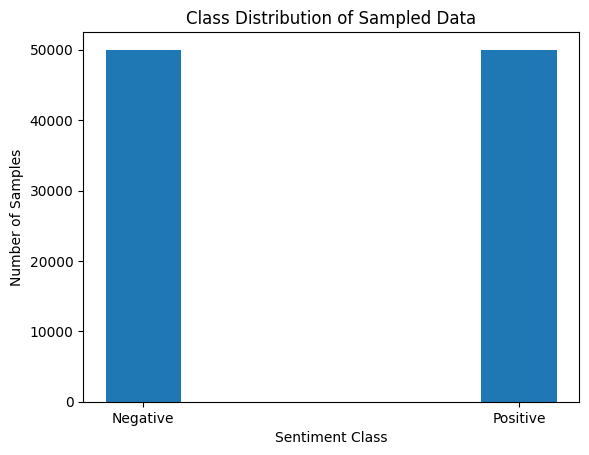

In [11]:
print(data.shape)
print(data['class'].value_counts())

class_dist = data['class'].value_counts()

plt.bar(class_dist.index, class_dist.values)
plt.xticks([0, 4], ['Negative', 'Positive'])
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Sampled Data')
plt.show()


# Data Pre-Processing

## Text cleaning

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()

    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # remove mentions
    text = re.sub(r'@\w+', '', text)

    # remove # (we will keep the words)
    text = re.sub(r'#', '', text)

    # remove special characters, numbers, ...
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # remove whitespace
    # text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # remove english stop words
    words = [word for word in word_tokenize(text) if word not in stop_words] # word_tokenize(text) will generate a list of tokenized sample

    # lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)



data['text'] = data['text'].apply(clean_text)
data.head()

,text,class
0,next weekend miss,0
1,yep bedroom flat cost k dont enough penny one,0
2,happy father day daddy miss dad today year ago...,0
3,let get two since want doberman,0
4,parent well sister alone house lonely people b...,0


## Data splitting
> splitted data (tokenized and padded)

In [30]:
X = data['text']
y = data['class']
y = y.replace(4, 1)

# training (80%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2024)

# validation (10%) and test (10%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024)

# tokenization
max_len = 50

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

max_words = len(tokenizer.word_index) + 1
print(max_words)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

# add padding
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_valid = pad_sequences(X_valid, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

51396


In [31]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(80000, 50) (80000,)
(10000, 50) (10000,)
(10000, 50) (10000,)


# Models

## Hyperparams
> can be modified

In [18]:
embedding_dim = 256
lstm_units = 256
dropout_rate = 0.5

lr = 0.001
optimizer = Adam(learning_rate=lr)
epochs = 20
batch_size = 64

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)



## 1 (simple model, 2 layers of LSTM)

In [19]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(256, return_sequences=False))
model.add(Dropout(dropout_rate))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,306,881 (4.99 MB)

 Trainable params: 1,306,881 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:

filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 18s - 15ms/step - accuracy: 0.5007 - loss: 0.6958 - val_accuracy: 0.5023 - val_loss: 0.6932
Epoch 2/20
1250/1250 - 20s - 16ms/step - accuracy: 0.4989 - loss: 0.6934 - val_accuracy: 0.5023 - val_loss: 0.6933
Epoch 3/20
1250/1250 - 20s - 16ms/step - accuracy: 0.5011 - loss: 0.6933 - val_accuracy: 0.4977 - val_loss: 0.6934
Epoch 4/20
1250/1250 - 17s - 13ms/step - accuracy: 0.5027 - loss: 0.6933 - val_accuracy: 0.4977 - val_loss: 0.6932


## 2 (Same but one dropout)

In [21]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(256, return_sequences=False))
# model.add(Dropout(dropout_rate)) (will remove the dropout layer this time)

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()


filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,306,881 (4.99 MB)

 Trainable params: 1,306,881 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 18s - 15ms/step - accuracy: 0.5011 - loss: 0.6936 - val_accuracy: 0.5023 - val_loss: 0.6932
Epoch 2/20
1250/1250 - 20s - 16ms/step - accuracy: 0.5438 - loss: 0.6812 - val_accuracy: 0.6372 - val_loss: 0.6418
Epoch 3/20
1250/1250 - 21s - 17ms/step - accuracy: 0.6976 - loss: 0.5762 - val_accuracy: 0.7342 - val_loss: 0.5274
Epoch 4/20
1250/1250 - 16s - 13ms/step - accuracy: 0.7471 - loss: 0.5130 - val_accuracy: 0.7422 - val_loss: 0.5181
Epoch 5/20
1250/1250 - 16s - 13ms/step - accuracy: 0.7547 - loss: 0.5001 - val_accuracy: 0.7419 - val_loss: 0.5070
Epoch 6/20
1250/1250 - 21s - 17ms/step - accuracy: 0.7608 - loss: 0.4911 - val_accuracy: 0.7485 - val_loss: 0.5070
Epoch 7/20
1250/1250 - 16s - 13ms/step - accuracy: 0.7617 - loss: 0.4871 - val_accuracy: 0.7471 - val_loss: 0.5053
Epoch 8/20
1250/1250 - 18s - 14ms/step - accuracy: 0.7710 - loss: 0.4740 - val_accuracy: 0.7462 - val_loss: 0.5107
Epoch 9/20
1250/1250 - 16s - 13ms/step -

## 3 (Bidirectional with one dropout)

In [22]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,882,049 (10.99 MB)

 Trainable params: 2,882,049 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

bidirectional_emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 39s - 31ms/step - accuracy: 0.7263 - loss: 0.5365 - val_accuracy: 0.7488 - val_loss: 0.5128
Epoch 2/20
1250/1250 - 42s - 34ms/step - accuracy: 0.7509 - loss: 0.5040 - val_accuracy: 0.7502 - val_loss: 0.5042
Epoch 3/20
1250/1250 - 40s - 32ms/step - accuracy: 0.7580 - loss: 0.4918 - val_accuracy: 0.7493 - val_loss: 0.5008
Epoch 4/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7632 - loss: 0.4816 - val_accuracy: 0.7463 - val_loss: 0.5053
Epoch 5/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7687 - loss: 0.4723 - val_accuracy: 0.7504 - val_loss: 0.5109
Epoch 6/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7764 - loss: 0.4616 - val_accuracy: 0.7443 - val_loss: 0.5116
Epoch 7/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7811 - loss: 0.4507 - val_accuracy: 0.7464 - val_loss: 0.5147
Epoch 8/20
1250/1250 - 42s - 33ms/step - accuracy: 0.7877 - loss: 0.4367 - val_accuracy: 0.7449 - val_loss: 0.5231


## 4 (same, with 2 dropouts)

In [23]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,882,049 (10.99 MB)

 Trainable params: 2,882,049 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

bidirectional_emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 39s - 31ms/step - accuracy: 0.7214 - loss: 0.5428 - val_accuracy: 0.7374 - val_loss: 0.5209
Epoch 2/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7493 - loss: 0.5069 - val_accuracy: 0.7462 - val_loss: 0.5080
Epoch 3/20
1250/1250 - 34s - 28ms/step - accuracy: 0.7570 - loss: 0.4940 - val_accuracy: 0.7495 - val_loss: 0.5029


## 5 (3 bidirectional layers)

In [25]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional(3_layers)_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 50, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 50, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,456,961 (17.00 MB)

 Trainable params: 4,456,961 (17.00 MB)

 Non-trainable params: 0 (0.00 B)

bidirectional(3_layers)_emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 116s - 93ms/step - accuracy: 0.7222 - loss: 0.5423 - val_accuracy: 0.7412 - val_loss: 0.5205
Epoch 2/20
1250/1250 - 80s - 64ms/step - accuracy: 0.7490 - loss: 0.5084 - val_accuracy: 0.7474 - val_loss: 0.5121
Epoch 3/20
1250/1250 - 82s - 66ms/step - accuracy: 0.7557 - loss: 0.4959 - val_accuracy: 0.7464 - val_loss: 0.5039


## 6

In [26]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
# model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional(3_layers)_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 50, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 50, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,456,961 (17.00 MB)

 Trainable params: 4,456,961 (17.00 MB)

 Non-trainable params: 0 (0.00 B)

bidirectional(3_layers)_emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 57s - 46ms/step - accuracy: 0.7216 - loss: 0.5412 - val_accuracy: 0.7439 - val_loss: 0.5093
Epoch 2/20
1250/1250 - 82s - 65ms/step - accuracy: 0.7497 - loss: 0.5051 - val_accuracy: 0.7451 - val_loss: 0.5064
Epoch 3/20
1250/1250 - 82s - 65ms/step - accuracy: 0.7560 - loss: 0.4943 - val_accuracy: 0.7514 - val_loss: 0.5031
Epoch 4/20
1250/1250 - 82s - 65ms/step - accuracy: 0.7619 - loss: 0.4855 - val_accuracy: 0.7436 - val_loss: 0.5060
Epoch 5/20
1250/1250 - 82s - 66ms/step - accuracy: 0.7653 - loss: 0.4788 - val_accuracy: 0.7446 - val_loss: 0.5116
Epoch 6/20
1250/1250 - 82s - 65ms/step - accuracy: 0.7710 - loss: 0.4703 - val_accuracy: 0.7476 - val_loss: 0.5116


## 7

In [34]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(dropout_rate))

# Additional dense layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Final dense layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional(3_layers)_Dense(more_layers)_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 50, 300)             │      15,418,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 50, 512)             │       1,140,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 50, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,783,857 (75.47 MB)

 Trainable params: 19,783,601 (75.47 MB)

 Non-trainable params: 256 (1.00 KB)

bidirectional(3_layers)_Dense(more_layers)_emb300_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 76s - 60ms/step - accuracy: 0.4984 - loss: 0.7358 - val_accuracy: 0.5023 - val_loss: 0.6932
Epoch 2/20
1250/1250 - 65s - 52ms/step - accuracy: 0.5018 - loss: 0.6942 - val_accuracy: 0.5023 - val_loss: 0.6932
Epoch 3/20
1250/1250 - 82s - 66ms/step - accuracy: 0.5038 - loss: 0.6938 - val_accuracy: 0.5023 - val_loss: 0.6931


## 8 (GRU)

In [32]:


model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(GRU(256, return_sequences=False))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"gru_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 50, 300)             │      15,418,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 256)             │         428,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,242,353 (61.96 MB)

 Trainable params: 16,242,353 (61.96 MB)

 Non-trainable params: 0 (0.00 B)

gru_emb300_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 35s - 28ms/step - accuracy: 0.5008 - loss: 0.6938 - val_accuracy: 0.4977 - val_loss: 0.6932
Epoch 2/20
1250/1250 - 26s - 21ms/step - accuracy: 0.4984 - loss: 0.6933 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 3/20
1250/1250 - 39s - 31ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5023 - val_loss: 0.6931


## 9

In [ ]:

filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

emb256_lstm256_dropout0_6_lr0_001.keras
Epoch 1/20
1250/1250 - 28s - 22ms/step - accuracy: 0.7506 - loss: 0.5147 - val_accuracy: 0.7471 - val_loss: 0.5126
Epoch 2/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7542 - loss: 0.5039 - val_accuracy: 0.7304 - val_loss: 0.5305
Epoch 3/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7594 - loss: 0.4962 - val_accuracy: 0.7433 - val_loss: 0.5223
Epoch 4/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7651 - loss: 0.4855 - val_accuracy: 0.7458 - val_loss: 0.5090
